# "Home Grown" Decision Tree in PySpark

This is our implementation of a Decision Tree in Spark, based on the [PLANET algorithm](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/36296.pdf)

In [1]:
from operator import itemgetter

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

from tree import DecisionTreeBinaryClassifier

In [2]:
# start Spark Session
from pyspark.sql import SparkSession
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel, LabeledPoint, RandomForest

app_name = "w261_tree_scratch"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Toy Example - Synthesized Data

First, I'll create fake data using a couple calls to `np.random.multivariate_normal` and assigning labels to them. We'll just see if we can reasonably classify some 2D data.

In [4]:
# how many examples in each class
n = 30000

pos = np.random.multivariate_normal((4, 0), ((1., -0.5), (-0.5, 1.)), n)
pos = np.hstack((pos, np.ones((n, 1)))) # add the labels
neg = np.random.multivariate_normal((5.5, 1.5), ((1., -0.5), (-0.5, 1.)), n)
neg = np.hstack((neg, np.zeros((n, 1)))) # add the labels

# put everything together and shuffle
data = np.vstack((pos, neg))
np.random.shuffle(data)

toyRDD = sc.parallelize(data).map(lambda row: (row[-1], row[:-1]))

In [5]:
# instantiate the model and train it
tree = DecisionTreeBinaryClassifier(2, {}, max_depth=6)
%time tree.train(toyRDD)
print(tree.tree_root)

CPU times: user 170 ms, sys: 60 ms, total: 230 ms
Wall time: 17.2 s
TreeNode(id=0, n=60000, gini_impurity=0.5, probability=0.5, split_feat=1, split_val=15)
├──TreeNode(id=1, n=29723, gini_impurity=0.3454504810274641, probability=0.7779833798741715, split_feat=0, split_val=22)
│  ├──TreeNode(id=3, n=22781, gini_impurity=0.12946953999489774, probability=0.9304244765374654, split_feat=0, split_val=17)
│  │  ├──TreeNode(id=7, n=18925, gini_impurity=0.06268367835909316, probability=0.9676089828269485, split_feat=0, split_val=14)
│  │  │  ├──TreeNode(id=15, n=16090, gini_impurity=0.03515786163983581, probability=0.9821006836544438, split_feat=1, split_val=12)
│  │  │  │  ├──TreeNode(id=31, n=13144, gini_impurity=0.018988458385396534, probability=0.9904138770541692, split_feat=0, split_val=11)
│  │  │  │  │  ├──Leaf(id=63, n=10479, gini_impurity=0.009875362174004643, probability=0.995037694436492)
│  │  │  │  │  └──Leaf(id=64, n=2665, gini_impurity=0.053992657230656604, probability=0.97223264

### Evaluation

Now that it's trained, we'll check the training accuracy and some other metrics to see how we did.

In [6]:
probs = tree.predict(toyRDD.map(itemgetter(1))).collect()
predictions = np.round(probs)
accuracy = np.mean(predictions == data[:, 2])
print(accuracy)
print(confusion_matrix(data[:, 2], predictions))
print(classification_report(data[:, 2], predictions))

0.93195
[[28153  1847]
 [ 2236 27764]]
             precision    recall  f1-score   support

        0.0       0.93      0.94      0.93     30000
        1.0       0.94      0.93      0.93     30000

avg / total       0.93      0.93      0.93     60000



### Plots

Finally, we'll plot the bins and the decision boundary because it's cool.

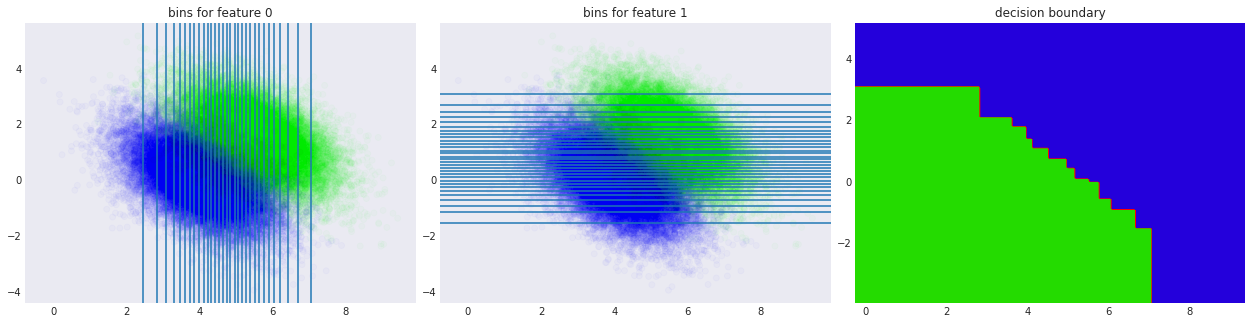

In [7]:
colors = np.array([[0., 1., 0., 0.02] if label == 0 else [0., 0., 1., 0.02] for label in data[:, 2]])

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(data[:, 0], data[:, 1], c=colors)
for i in tree.continuous_bins[0]:
    plt.axvline(x=i)
plt.gca().set_title("bins for feature 0")

plt.subplot(1, 3, 2)
plt.scatter(data[:, 0], data[:, 1], c=colors)
for i in tree.continuous_bins[1]:
    plt.axhline(y=i)
plt.gca().set_title("bins for feature 1")
    
plt.subplot(1, 3, 3)
plot_step = 0.05

x_min, x_max = data[:, 0].min(), data[:, 0].max()
y_min, y_max = data[:, 1].min(), data[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
plt.gca().set_title("decision boundary")

meshRDD = sc.parallelize(np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1))))
z = tree.predict(meshRDD).collect()
z = np.array(z).round().reshape(xx.shape)
cs = plt.contourf(xx, yy, z, cmap=plt.cm.brg)

## Scikit-learn Breast Cancer Dataset

Now, we'll check out a more realistic dataset. The Breast Cancer Dataset is another binary classification task, but with 30 features.

In [8]:
from sklearn.datasets import load_breast_cancer

breast_cancer_data = load_breast_cancer()
cancerRDD = sc.parallelize(zip(breast_cancer_data.target, breast_cancer_data.data))

cancer_tree = DecisionTreeBinaryClassifier(breast_cancer_data.data.shape[1], {}, max_depth=6, feature_subset_strategy="sqrt")
%time cancer_tree.train(cancerRDD)
print(cancer_tree.tree_root)

CPU times: user 180 ms, sys: 30 ms, total: 210 ms
Wall time: 2.75 s
TreeNode(id=0, n=569, gini_impurity=0.4675300607546925, probability=0.6274165202108963, split_feat=27, split_val=20)
├──TreeNode(id=1, n=378, gini_impurity=0.16371322191428028, probability=0.91005291005291, split_feat=0, split_val=21)
│  ├──TreeNode(id=3, n=341, gini_impurity=0.06243496357960443, probability=0.967741935483871, split_feat=23, split_val=18)
│  │  ├──TreeNode(id=7, n=312, gini_impurity=0.025312294543063718, probability=0.9871794871794872, split_feat=10, split_val=26)
│  │  │  ├──TreeNode(id=15, n=307, gini_impurity=0.019352990482657706, probability=0.990228013029316, split_feat=20, split_val=16)
│  │  │  │  ├──TreeNode(id=29, n=285, gini_impurity=0.006992920898738042, probability=0.9964912280701754, split_feat=9, split_val=13)
│  │  │  │  │  ├──Leaf(id=45, n=112, gini_impurity=0.017697704081632626, probability=0.9910714285714286)
│  │  │  │  │  └──Leaf(id=46, n=173, gini_impurity=0.0, probability=1.0)
│  

In [9]:
probs = cancer_tree.predict(cancerRDD.map(itemgetter(1))).collect()
predictions = np.round(probs)
accuracy = np.mean(predictions == breast_cancer_data.target)
print(accuracy)
print(confusion_matrix(breast_cancer_data.target, predictions))
print(classification_report(breast_cancer_data.target, predictions))

0.9947275922671354
[[210   2]
 [  1 356]]
             precision    recall  f1-score   support

          0       1.00      0.99      0.99       212
          1       0.99      1.00      1.00       357

avg / total       0.99      0.99      0.99       569

